In [43]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pytorch_model_summary

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image

from tqdm import tqdm
from scipy import io

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('use: ',device)

use:  cuda


In [3]:
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
mat_file = io.loadmat('./data/lsp_dataset/joints.mat')

In [5]:
annotation = np.transpose(mat_file['joints'], (2,1,0))

In [55]:
image = Image.open('./data/lsp_dataset/images/im0005.jpg')
np.shape(image)

(175, 102, 3)

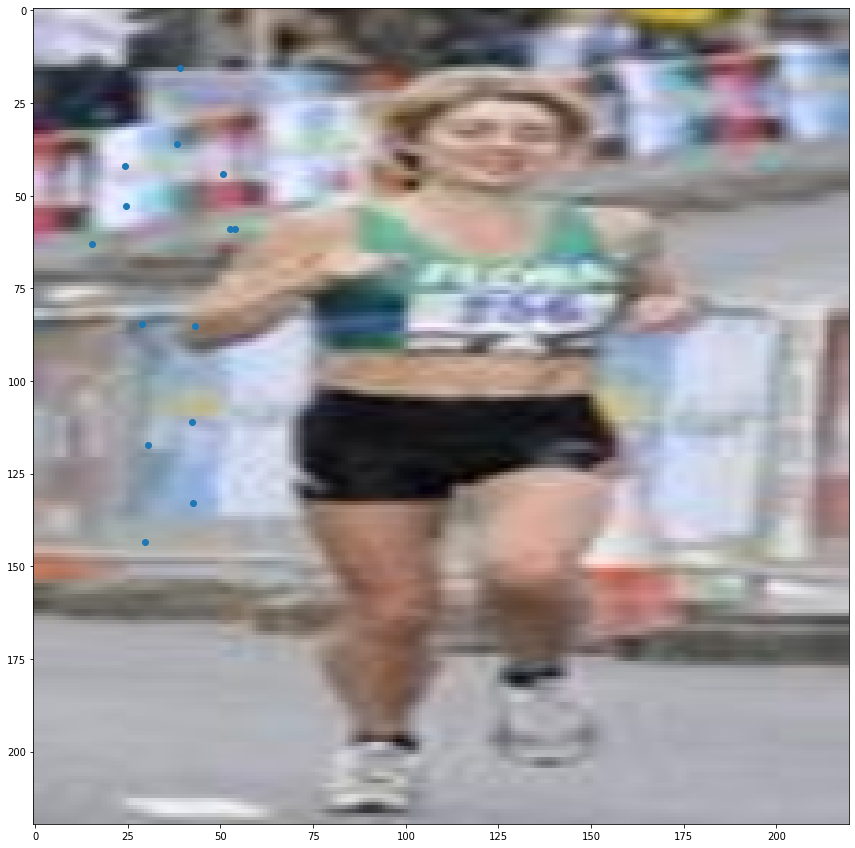

In [50]:
'''
160x70 -> 220x220 바로 가능?
70x70으로 자르고 해야하나?

'''

image = Image.open('./data/lsp_dataset/images/im0001.jpg')
re_image = image.resize((220,220))

fig = plt.figure(figsize=(20,15))
plt.imshow(re_image)
plt.scatter(annotation[0,:,:1], annotation[0,:,1:2])
plt.show()

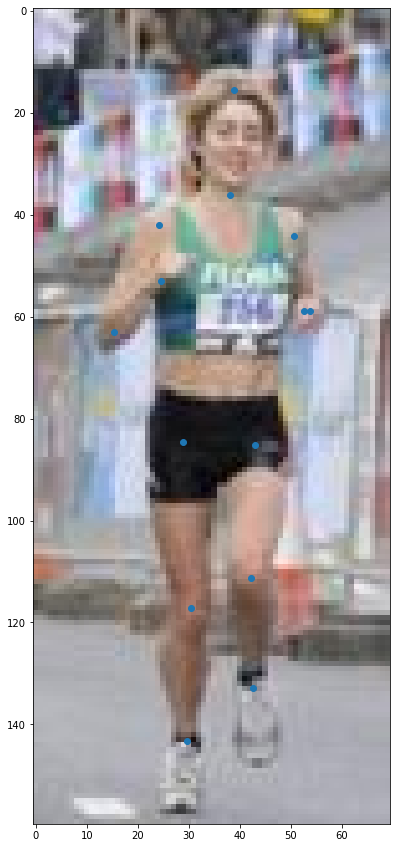

In [6]:
fig = plt.figure(figsize=(20,15))
image = img.imread('./data/lsp_dataset/images/im0001.jpg')
plt.imshow(image)
plt.scatter(annotation[0,:,:1], annotation[0,:,1:2])
plt.show()

In [7]:
image.shape

(160, 70, 3)

In [39]:
'''
input image resize (220,220,3)?
LRN -> BN

'''

class DeepPose(nn.Module):
    def __init__(self, njoints=14):
        super(DeepPose, self).__init__()
        
        self.joints = njoints
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(9216, 4096),
            nn.Linear(4096, 2*self.joints),
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1) # flatten
        out = self.fc(out)
        return out

In [40]:
model = DeepPose()

In [42]:
print(pytorch_model_summary.summary(model, torch.zeros(1,3,220,220),show_input=True))

------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
          Conv2d-1     [1, 3, 220, 220]          34,944          34,944
     BatchNorm2d-2      [1, 96, 53, 53]             192             192
       MaxPool2d-3      [1, 96, 53, 53]               0               0
            ReLU-4      [1, 96, 26, 26]               0               0
          Conv2d-5      [1, 96, 26, 26]         614,656         614,656
     BatchNorm2d-6     [1, 256, 24, 24]             512             512
       MaxPool2d-7     [1, 256, 24, 24]               0               0
            ReLU-8     [1, 256, 12, 12]               0               0
          Conv2d-9     [1, 256, 12, 12]         885,120         885,120
           ReLU-10     [1, 384, 12, 12]               0               0
         Conv2d-11     [1, 384, 12, 12]       1,327,488       1,327,488
           ReLU-12     [1, 384, 12, 12]               0        